#TIME SERIES ANALYSIS

#Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

##DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP. You can get it in the github repo as well as here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy. 

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


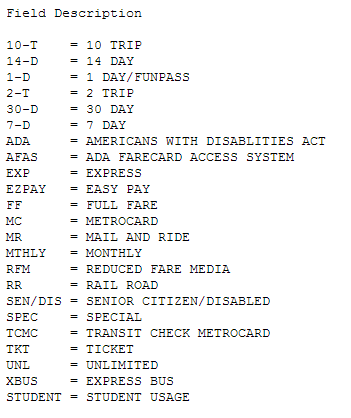

In [1]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

Each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/21/2010 to 02/21/2014. 

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

##note that the missing values are inputted as -1

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

#Task 1: 
##Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
##Identify it and figure out what it is due to.


#Task 2: 
##Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


#Task 3:
##Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)


#EXTRA CREDIT: Cluster. 
##Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
##Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

##i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T

##removing empty light curves
tots = tots[tots.std(1)>0]

##with Kmeans you have to choose the number of clusters ahead km = 

KMeans(n_clusters=10)

##and standardize the lightcurves before clustering
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

##then you can run:

km.fit(vals)

#HINTS: 

##When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average)


#Possibly useful functions

##I used a variety of functions, most of them you are familiar with already. here are a few that you may not have encountered yet which I used. 
##(But you do not have to use them! there are many ways to do things and you do not have to solve this problem like I did)

* the numpy function np.where() returns the index where a condition is true. it is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


* to find periodicity you can use fourier transforms. if you choose to use the numpy package you may want to use the real fft function:  np.fft.rfft  
     
     np.fft.rfft(mydata) 
     
     will return the fourier transform, but what you want is its absolute value: np.abs(). Then to get the x axis of your plot in frequency (1/week since the data is in weeks) you can use the function 

     np.fft.rfftfreq(N, d) 
     
     which takes as arguments N = the length of your time series (the number of datapoints) and d: the Sample spacing, or 1.0/sampling_rate (in this case, with 1/week sampling, if you want the freq in units of week that is just 1)


*  the np.array.flatten() and np.array.reshape() allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which i recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series)



##NOTE ON THE TREND DETECTION:
###you should find the ride type that has the steepest increase, and the steepest decrease. notice: we are looking for something that has a more or less constant trend
###to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type.
###you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the flux near the beginning to the flux near the end of the time series.
###notice that you should inspect the time series, either algorithmically or by eye, to ensure you see a trend, and not just changing structure.
###below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series

##to determine if there is a trend or strucutre you can inspect the time series visually, since there are only 23!
##an alternative, algorithmic way to do it, is to fit a line to the (smoothed) time series  and look at the residuals.

In [36]:
#from __future__ import division
import pandas as pd
#from mpl_toolkits.mplot3d import Axes3D         # Cargo Axes3D de mpl_toolkits.mplot3d
#from scipy.misc import imread                   # Cargo imread de scipy.misc
                           # Cargo numpy como el aliaas np
import matplotlib.pyplot as plt                 # Cargo matplotlib.pyplot  en el alias sp
import matplotlib.dates as mdates
import statsmodels.api as sm
import pylab as pl
import datetime
from statsmodels.graphics.api import qqplot

%matplotlib inline # moved up
import matplotlib.pylab

import numpy as np   

UsageError: unrecognized arguments: # moved up

In [20]:
mta1 = np.load("MTA_Fare.npy")

In [21]:
#after reading the datacube you should see:
mta1.shape



(600, 23, 194)

In [22]:
print mta1[100]


[[37156 38221 38629 ..., 44851 41437 41254]
 [ 1247  1354  1360 ...,  1868  1810  1754]
 [  254   270   287 ...,   316   284   307]
 ..., 
 [    0     0     0 ...,     0     0     0]
 [    0     0     0 ...,     0     0     0]
 [   -1    -1    -1 ...,  5359  6694  2885]]


In [23]:
#Knowing type of data
mta1.dtype


dtype('int32')

In [24]:
#nan are float, then we have to change the data to float
mta1 = mta1.astype(float)
mta1.dtype

dtype('float64')

In [25]:
#Create a function to replace a number with nan
def replaceNoData3d(scanBlock, NDV):
    for n1, sB1 in enumerate(scanBlock):
        for  n2, sB2 in enumerate(sB1):
            for n3, elem in enumerate(sB2):
                if elem == NDV:
                    scanBlock[n1][n2][n3] = np.nan
replaceNoData3d(mta1,-1)
#mta2 = where(mta1<0, 'NaN', mta1)

In [124]:
#Checking
print mta1[100]



[[ 37156.  38221.  38629. ...,  44851.  41437.  41254.]
 [  1247.   1354.   1360. ...,   1868.   1810.   1754.]
 [   254.    270.    287. ...,    316.    284.    307.]
 ..., 
 [     0.      0.      0. ...,      0.      0.      0.]
 [     0.      0.      0. ...,      0.      0.      0.]
 [    nan     nan     nan ...,   5359.   6694.   2885.]]


In [10]:
#Task 1:
##Event detection: Identify the most prominent event. 
#There is a very significant drop (>3-sigma) in all time series.
##Identify it and figure out what it is due to.

#Grouping all the elements of the 600 swipes and the 23 types of cards
#Adding all of them in one sum per week to identify the big drop
events = np.nansum(mta1,axis=(0,1))


In [126]:
events.shape

(194,)

In [8]:
#Creating definition of weeks
weeks = pd.date_range(start='2010-05-21',end='2014-01-31',freq='7D')
#weeks = pd.date_range('05/21/2010', periods=194, freq='7D')


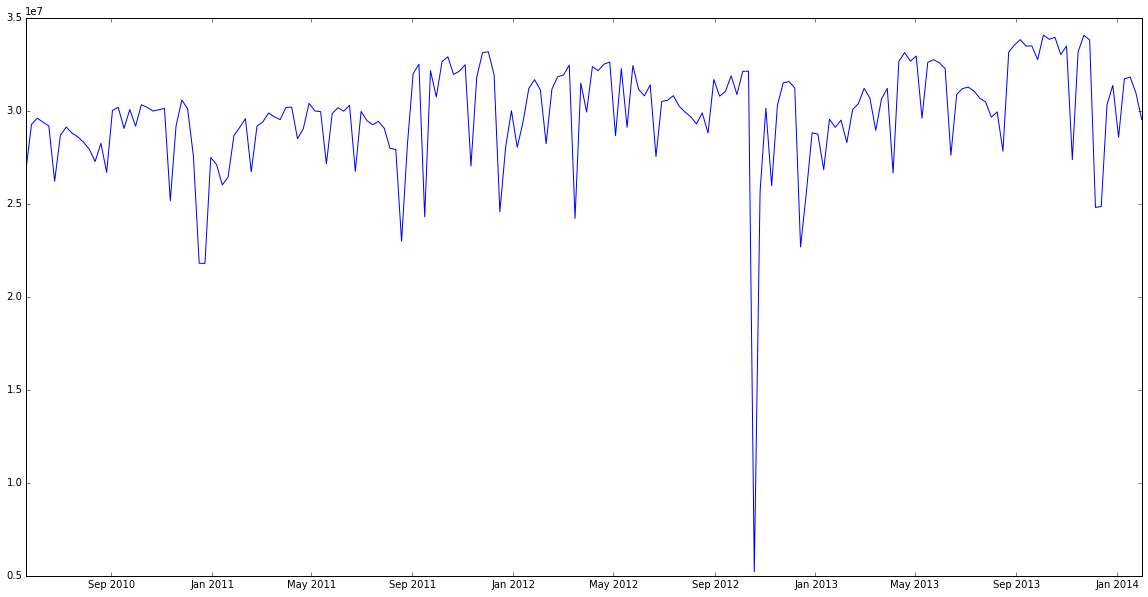

In [11]:
#Creating the plot
plt.figure(figsize(20,10))
plt.plot_date(x=weeks, y=events,fmt='-')

In [129]:
#In the graph showed above, all the card swipes and the and the 23 types 
#of cards were added, here we can observe a very significant drop
#in October 2012, Hurricane Sandy, the time of this event was 
# from october 22 and  Dissipated until November 2, 2012.


In [130]:
#Identifying exactly  (>3-sigma) in all time series.

In [131]:
#Create an upper and lower thresholds, mean + 3 sigma 
upperthresholds = events.mean() + 3*events.std()
lowerthresholds = events.mean() - 3*events.std()
#Now Calculate Period of Time where it occured

print '%s is the mean of all time series' % (events.mean())
print '%s is the standard deviation of all time series' % (events.std())
print '%s is the date that is below 3 standard deviations '% weeks[Lowweeks[0][0]]

29781349.8711 is the mean of all time series
2983960.4217 is the standard deviation of all time series
2012-10-19 00:00:00 is the date that is below 3 standard deviations 


Task 2: stationarity and trends
Identify the ridership types that have steadily increased in popularity, and that have steadily decreased
By how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [132]:
typecards = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez','ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t','umlim','xbus','stud'])


In [44]:
#Grouping by ridership types
sumswipes= np.nansum(mta1,axis=0)

sumswipes.shape

(23, 194)

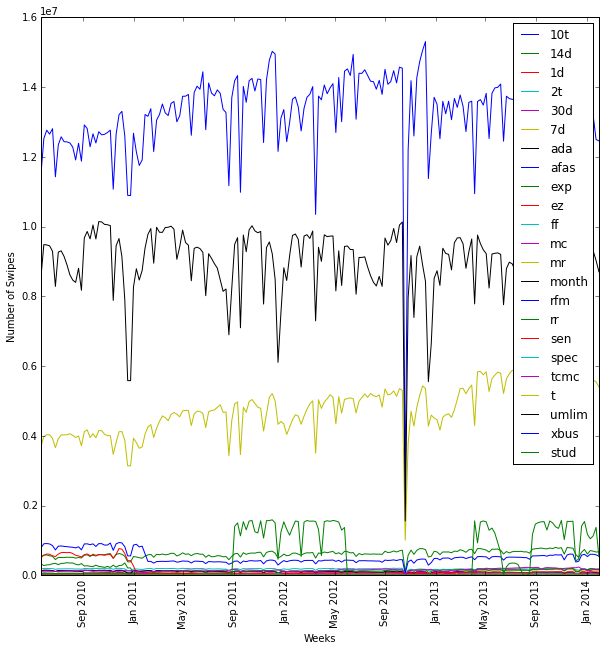

In [43]:
#Plotting
plt.figure(figsize=(10, 10), dpi=200)
ax = pl.plot(weeks, np.transpose(sumswipes))
pl.ylabel('Number of Swipes')
pl.xlabel('Weeks')
pl.xticks(rotation = 90)
pl.legend(typecards)


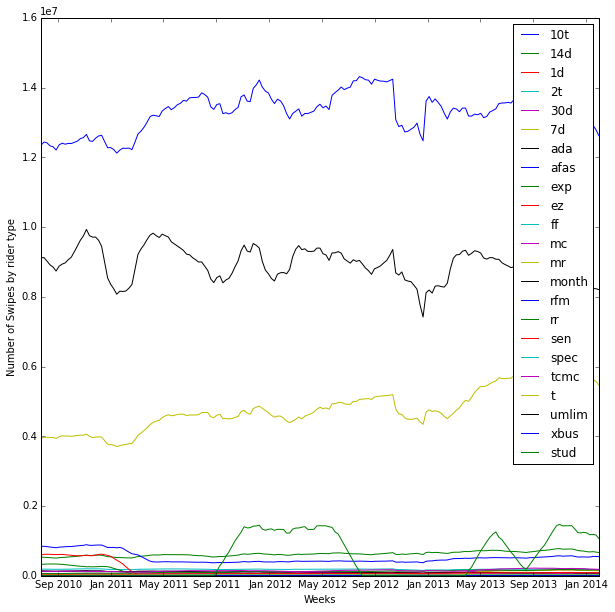

In [45]:
#Smoothing the timeseries
plt.figure(figsize=(10, 10), dpi=200)
smoothridertypes = pd.rolling_mean(np.transpose(sumswipes), 10)
ax = pl.plot(weeks, smoothridertypes)
pl.ylabel('Number of Swipes by rider type')
pl.xlabel('Weeks')
pl.legend(typecards)
